In [1]:
#matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import opensfm
import cv2
from opensfm import dataset, features, io
import json

import torch
import torch.optim as optim
import ngransac

from network import CNNet
from dataset import SparseDataset
import util
import pdb

matplotlib.rcParams['figure.figsize'] = (12, 12)

In [2]:
path = '/home/ubuntu/projects/OpenSfM/data/gezer/'
data = dataset.DataSet(path)

In [3]:
camera = data.load_camera_models(); camera

{'v2 dji fc300s 4000 3000 perspective 0.5555': PerspectiveCamera('v2 dji fc300s 4000 3000 perspective 0.5555', 'perspective', 4000, 3000, 0.5555555555555556, 0.0, 0.0, 0.5555555555555556, 0.0, 0.0)}

In [4]:
camera_name = list(camera.keys())[0]

In [5]:
camera = camera[camera_name]; camera

PerspectiveCamera('v2 dji fc300s 4000 3000 perspective 0.5555', 'perspective', 4000, 3000, 0.5555555555555556, 0.0, 0.0, 0.5555555555555556, 0.0, 0.0)

In [6]:
K = camera.get_K_in_pixel_coordinates(); K

array([[2.22222222e+03, 0.00000000e+00, 1.99950000e+03],
       [0.00000000e+00, 2.22222222e+03, 1.49950000e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [7]:
# notes: normalize_pts as defined in /home/ubuntu/projects/OpenSfM/opensfm/features.py

In [8]:
# hack stuff to directory ngransac:
# image1 = '../../ngransac/images/demo1.jpg'
# image2 = '../../ngransac/images/demo2.jpg' 
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
image1 = '/home/ubuntu/projects/OpenSfM/data/gezer/images/DJI_0065.JPG'
image2 = '/home/ubuntu/projects/OpenSfM/data/gezer/images/DJI_0066.JPG'

Current size: [6.0, 4.0]


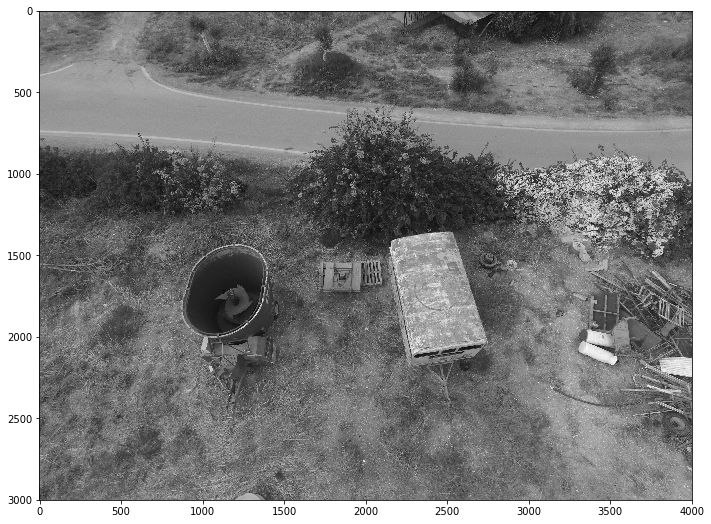

In [9]:
# read images
img1 = cv2.imread(image1)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
plt.imshow(img1, cmap='gray')

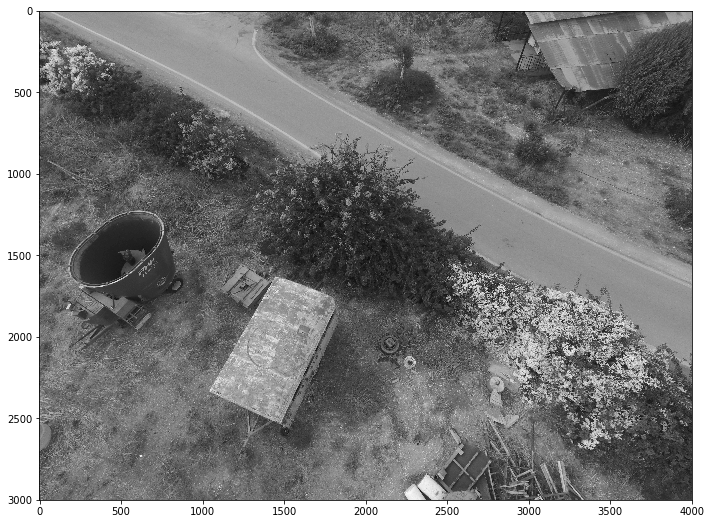

In [10]:
img2 = cv2.imread(image2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
plt.imshow(img2, cmap='gray')

In [11]:
nfeatures = 8000
detector  = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures, contrastThreshold=1e-5)

# detect features
kp1, desc1 = detector.detectAndCompute(img1, None)
kp2, desc2 = detector.detectAndCompute(img2, None)

# feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)

good_matches = []
pts1 = []
pts2 = []

ratio=1.0 
#side information for the network (matching ratios in this case)
ratios = []

print("")
if ratio < 1.0:
	print("Using Lowe's ratio filter with", ratio)

for (m,n) in matches:
	if m.distance < ratio*n.distance: # apply Lowe's ratio filter
		good_matches.append(m)
		pts2.append(kp2[m.trainIdx].pt)
		pts1.append(kp1[m.queryIdx].pt)
		ratios.append(m.distance / n.distance)

print("Number of valid matches:", len(good_matches))

pts1 = np.array([pts1])
pts2 = np.array([pts2])

ratios = np.array([ratios])
ratios = np.expand_dims(ratios, 2)


Number of valid matches: 8000


In [12]:
class NGRansac:
    
    # init model with default params. Calculate only fundamental matrix
    def __init__(self,
                 frame_size,           
                 K = None,
                 batchsize=32,
                 fmat=False,
                 hyps=4000,
                 model='',
                 nfeatures=2000,
                 nosideinfo=False,                 
                 orb=False,
                 ratio=1.0,
                 refine=True,
                 resblocks=12,
                 rootsift=False,
                 session='',
                 threshold=0.001):
        
        print(K)
        if fmat:
            print("\nFitting Fundamental Matrix...\n")
        else:
            print("\nFitting Essential Matrix...\n")
        
        # load network
        model_file = model
        if len(model_file) == 0:
            model_file = util.create_session_string('e2e', fmat, orb, rootsift, ratio, session)
            model_file = '../../ngransac/models/weights_' + model_file + '.net'            
            print('Loading pre-trained model:', model_file)
            
        model = CNNet(resblocks)
        model.load_state_dict(torch.load(model_file))
        model = model.cuda()
        model.eval()        
        print('model ', model_file, ' successfully loaded.')                                    
        
        self.model      = model
        self.frame_size = frame_size
        self.nosideinfo = nosideinfo
        self.hyps       = hyps
        self.threshold  = threshold
        self.refine     = refine
        self.K = K
        
    
    def findEssentialMat(self, pts1, pts2, ratios):
        
        print(self.K)
        assert self.K is not None, 'To calculate E, K must be NOT NONE'
        
        pts1 = cv2.undistortPoints(pts1, self.K, None)
        pts2 = cv2.undistortPoints(pts2, self.K, None)
        
        
        if self.nosideinfo:
            # remove side information before passing it to the network
            ratios = np.zeros(ratios.shape)
        
        # create data tensor of feature coordinates and matching ratios
        correspondences = np.concatenate((pts1, pts2, ratios), axis=2)
        correspondences = np.transpose(correspondences)
        correspondences = torch.from_numpy(correspondences).float()

        # predict neural guidance, i.e. RANSAC sampling probabilities
        log_probs = self.model(correspondences.unsqueeze(0).cuda())[0] #zero-indexing creates and removes a dummy batch dimension
        probs = torch.exp(log_probs).cpu()

        out_model     = torch.zeros((3, 3)).float() # estimated model
        out_inliers   = torch.zeros(log_probs.size()) # inlier mask of estimated model
        out_gradients = torch.zeros(log_probs.size()) # gradient tensor (only used during training)
        rand_seed     = 0 # random seed to by used in C++
        
        
        incount = ngransac.find_essential_mat(correspondences, 
                                              probs, 
                                              rand_seed, 
                                              self.hyps, 
                                              self.threshold, 
                                              out_model, 
                                              out_inliers, 
                                              out_gradients)
        
        print("\n=== Model found by NG-RANSAC: =======\n")
        print("\nNG-RANSAC Inliers: ", int(incount))
        
        out_inliers = out_inliers.byte().numpy().ravel().tolist()
        
        # Fundamental matrix
        return out_model.numpy(), out_inliers
    
    # pts1 and pts2 must be normalized to the frame size before running the procedure below
    # as well the ratios must be computed
    def findFundamentalMat(self, pts1, pts2, ratios):
        
        # normalize x and y coordinates before passing them to the network
        # normalized by the image size
        util.normalize_pts(pts1, self.frame_size)
        util.normalize_pts(pts2, self.frame_size)
        
        if self.nosideinfo:
            # remove side information before passing it to the network
            ratios = np.zeros(ratios.shape)
        
        # create data tensor of feature coordinates and matching ratios
        correspondences = np.concatenate((pts1, pts2, ratios), axis=2)
        correspondences = np.transpose(correspondences)
        correspondences = torch.from_numpy(correspondences).float()

        # predict neural guidance, i.e. RANSAC sampling probabilities
        log_probs = self.model(correspondences.unsqueeze(0).cuda())[0] #zero-indexing creates and removes a dummy batch dimension
        probs = torch.exp(log_probs).cpu()

        out_model     = torch.zeros((3, 3)).float() # estimated model
        out_inliers   = torch.zeros(log_probs.size()) # inlier mask of estimated model
        out_gradients = torch.zeros(log_probs.size()) # gradient tensor (only used during training)
        rand_seed     = 0 # random seed to by used in C++
        
        # run NG-RANSAC
        # === CASE FUNDAMENTAL MATRIX =========================================

        # undo normalization of x and y image coordinates
        util.denormalize_pts(correspondences[0:2], self.frame_size)
        util.denormalize_pts(correspondences[2:4], self.frame_size)
        
        incount = ngransac.find_fundamental_mat(correspondences, 
                                                probs, 
                                                rand_seed, 
                                                self.hyps, 
                                                self.threshold, 
                                                self.refine, 
                                                out_model, 
                                                out_inliers, 
                                                out_gradients)
        
        print("\n=== Model found by NG-RANSAC: =======\n")
        print("\nNG-RANSAC Inliers: ", int(incount))
        
        out_inliers = out_inliers.byte().numpy().ravel().tolist()
        
        # Fundamental matrix
        return out_model.numpy(), out_inliers
    
        

In [13]:
ng = NGRansac(frame_size=img1.shape, K=K)

[[2.22222222e+03 0.00000000e+00 1.99950000e+03]
 [0.00000000e+00 2.22222222e+03 1.49950000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Fitting Essential Matrix...

Loading pre-trained model: ../../ngransac/models/weights_e2e_E_r1.00_.net
model  ../../ngransac/models/weights_e2e_E_r1.00_.net  successfully loaded.


In [14]:
E, inliers = ng.findEssentialMat(pts1, pts2, ratios)

[[2.22222222e+03 0.00000000e+00 1.99950000e+03]
 [0.00000000e+00 2.22222222e+03 1.49950000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

=== Model found by NG-RANSAC: =======


NG-RANSAC Inliers:  328


In [15]:
print('E = ', E)

E =  [[ 0.0175693   0.02616549 -0.0147323 ]
 [ 0.15079275 -0.03514266 -0.6897413 ]
 [ 0.32417765  0.6264232   0.03969903]]


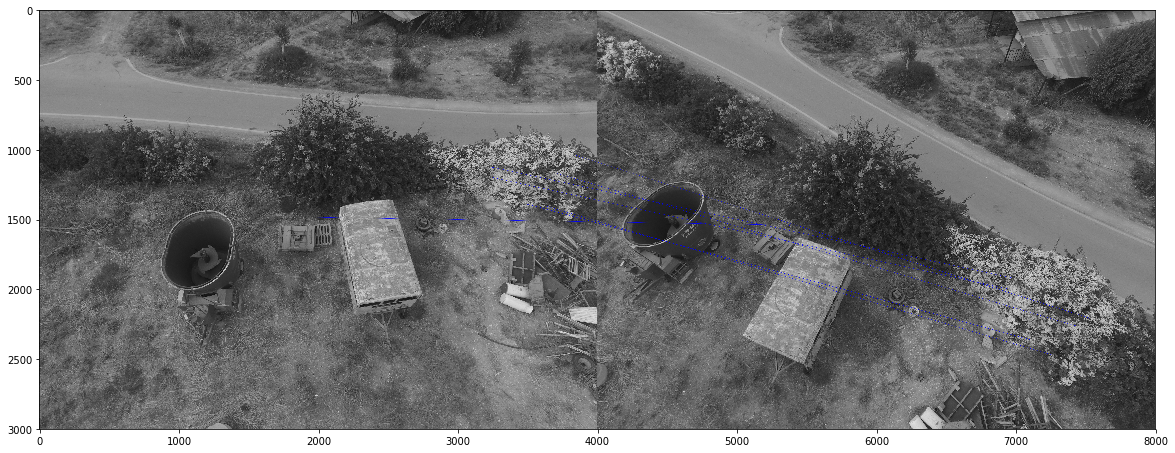

In [16]:
inx = 100
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size
match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:inx], None, flags=2, matchColor=(0,0,255), matchesMask = inliers[:inx])
plt.imshow(match_img_ngransac)

In [17]:
pt1 = np.int64(np.squeeze(pts1))
pt2 = np.int64(np.squeeze(pts2))

In [18]:
img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

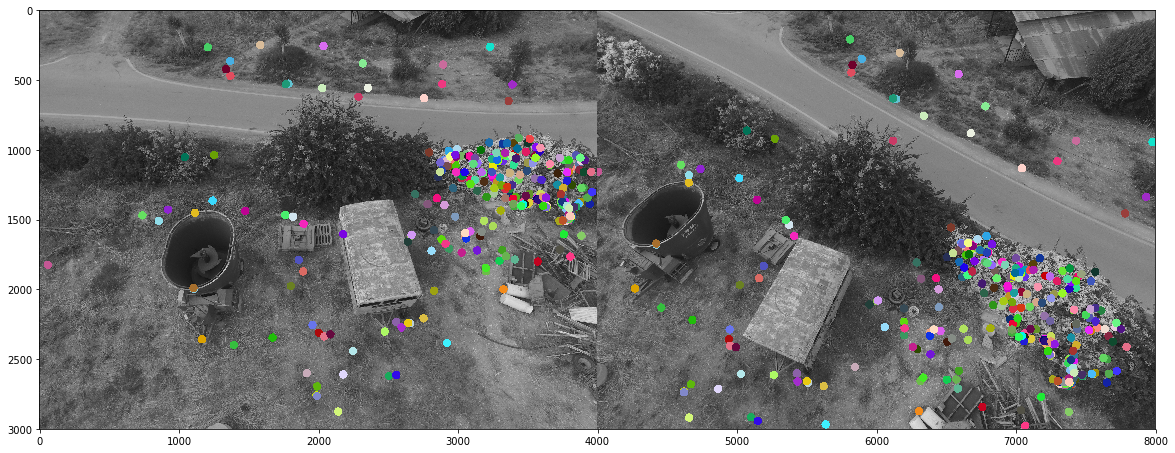

In [19]:

radius = 30
for i, _in in enumerate(inliers):
    if _in:
        position = (pt1[i, 0], pt1[i, 1])   
        color = np.uint8(np.random.randint(255, size=(3)))
#         color = (col[0], col[1], col[2])
        c = tuple(map(int, color))
#         print(color)
        cv2.circle(img1, position, radius, color=c, thickness=-1)
        position = (pt2[i, 0], pt2[i, 1])
        cv2.circle(img2, position, radius, color=c, thickness=-1)
        
plt.imshow(np.concatenate([img1, img2], axis=1))

In [20]:
len(inliers)

8000